In [2]:
### Section 1 - First, let's import everything we will be needing.

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from fine_tuning_config_file import *

## If you want to keep a track of your network on tensorboard, set USE_TENSORBOARD TO 1 in config file.

if USE_TENSORBOARD:
    from pycrayon import CrayonClient
    cc = CrayonClient(hostname=TENSORBOARD_SERVER)
    try:
        cc.remove_experiment(EXP_NAME)
    except:
        pass
    foo = cc.create_experiment(EXP_NAME)


## If you want to use the GPU, set GPU_MODE TO 1 in config file

use_gpu = GPU_MODE
if use_gpu:
    torch.cuda.set_device(CUDA_DEVICE)

count=0

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
use_gpu

1

In [5]:
data_dir = DATA_DIR
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=25)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

In [79]:
dset_classes

['fake', 'real']

# Checking Data Loading

In [16]:
for data in dset_loaders['train']:
    inputs, labels = data
#     break
    print(inputs.size())
    inputs = Variable(inputs.float().cuda())                            
    labels = Variable(labels.long().cuda())
    

torch.Size([10, 3, 224, 224])


In [14]:
inputs = Variable(inputs.float().cuda())

In [15]:
labels = Variable(labels.long().cuda())

# Is it really able to differentiate?

In [8]:
model_ft = torch.load('fine_tuned_best_model.pt')

In [85]:
for data in dset_loaders['val']:
    inputs, labels = data
    inputs = Variable(inputs.float().cuda())
    labels = Variable(labels.long().cuda())
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs.data, 1)
    break

In [107]:
batch_perf = torch.sum(labels == preds).item()/len(preds)
print(batch_perf)

1.0


In [108]:
def denormalize_and_show(input_im):
    numarr = input_im.detach().cpu().numpy().transpose(1,2,0)
    numarr[:,:,0] *= 0.229
    numarr[:,:,1] *= 0.224
    numarr[:,:,2] *= 0.225

    numarr[:,:,0] += 0.485
    numarr[:,:,1] += 0.456
    numarr[:,:,2] += 0.406
    plt.imshow(numarr)
    plt.axis('off')

0
0


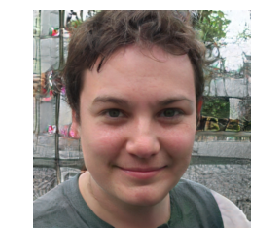

In [109]:
ID = 20
denormalize_and_show(inputs[ID])
print(labels[ID].item())
print(preds[ID].item())

In [110]:
# Compare learned features?